In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import torch

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *
from unmixing_algorithms import *

set_plotting_style('latex')

### Load extinction spectra of endmembers

from literature

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_simple = (band_centers/500)**(-1.2)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")

endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]
M_scatter_simple = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_lit = smooth_spectral(M_scatter_simple.T,5).T

from MC simulations

In [3]:
spectra_folder = "../mc_sim/spectra_mc/"

hb_mc = np.loadtxt(spectra_folder + "m_hhb_50.txt")
hbo2_mc = np.loadtxt(spectra_folder + "m_hbo2_50.txt")
cyt_c_ox_mc = np.loadtxt(spectra_folder + "m_cyt_c_ox_20.txt")
cyt_c_red_mc = np.loadtxt(spectra_folder + "m_cyt_c_red_20.txt")
cyt_b_ox_mc = np.loadtxt(spectra_folder + "m_cyt_b_ox_20.txt")
cyt_b_red_mc = np.loadtxt(spectra_folder + "m_cyt_b_red_20.txt")
cyt_oxi_ox_mc = np.loadtxt(spectra_folder + "m_cyt_oxi_ox_20.txt")
cyt_oxi_red_mc = np.loadtxt(spectra_folder + "m_cyt_oxi_red_20.txt")
scatter_mc = np.loadtxt(spectra_folder + "m_scatter_40.txt")
water_mc = np.loadtxt(spectra_folder + "m_water_200.txt")
fat_mc = np.loadtxt(spectra_folder + "m_fat_200.txt")

endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]
M_mc = np.vstack((cyt_c_ox_mc, cyt_c_red_mc, cyt_b_ox_mc, cyt_b_red_mc, cyt_oxi_ox_mc, cyt_oxi_red_mc, hb_mc, hbo2_mc, water_mc, fat_mc, scatter_mc)).T
M_mc = smooth_spectral(M_mc.T,5).T

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


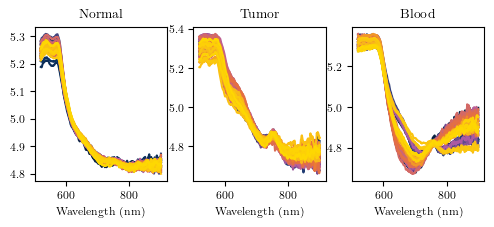

In [26]:
img = "043-01"
data_folder = f"../../datasets/npj_database/{img}"
absorbance = np.load(data_folder + "/preprocessed.npy")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")


normal_idxs = np.where(gt_map.asarray() == 1)
ref_absorbance = absorbance[normal_idxs[0][0],normal_idxs[1][0]]
rel_absorbance = absorbance - ref_absorbance

fig, axs = plot_class_spectra(absorbance, gt_map, nspectr=50, bands=band_centers, figsize=(5.8,2), legend_loc='upper right')

In [12]:
def plot_concentrations(c, endmember_labels=None, figsize=(5.8,2.3)):
    '''
    Plot the concentration maps of the endmembers. The concentration maps are normalized to the range [0,1], and the colorbar is added to the last subplot.
    input:
        c: np.array, shape (L, M, N) where N is the number of endmembers
        endmember_labels: list of strings containing the endmember labels
        figsize: tuple, the size of the figure
        normalize: bool, if True, the concentration maps are normalized to the range [0,1]
    output:
        fig: figure handle to the plot
        axs: axes handle to the plot
    '''
    N = c.shape[2]
    ncol = 4
    nrow = int(np.ceil((N+1)/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    for i in range(nrow*ncol):
        axs[i//ncol,i%ncol].axis("off")
        if i >= N:
            continue
        im = axs[i//ncol,i%ncol].imshow(c[:,:,i], cmap=tum_cmap)
        axs[i//ncol,i%ncol].set_title(endmember_labels[i])
        # add cbar to the image
        divider = make_axes_locatable(axs[i//ncol,i%ncol])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(axs[i//ncol,i%ncol].images[0], cax=cax)
    fig.tight_layout()
    return fig, axs

In [21]:
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
def lmm_unmixing(absorbance, M, filename=None, plot_hm=False, gt_map=None):
    data, err = unmix_LS_unconstrained(M, absorbance)
    if filename is not None:
        np.save(os.path.join("../../datasets/npj_database",filename), data)
    if plot_hm:
        fig_heatmaps, _ = plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=(5.8,3.5))
        fig_heatmaps.tight_layout()
        return fig_heatmaps

def nonneg_lmm_unmixing(absorbance, M, filename=None, plot_hm=False, gt_map=None):
    data, err = unmix_LS_nonnegative(M, absorbance)
    if filename is not None:
        np.save(os.path.join("../../datasets/npj_database",filename), data)
    if plot_hm:
        fig_heatmaps, _ = plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=(5.8,3.5))
        fig_heatmaps.tight_layout()
        return fig_heatmaps

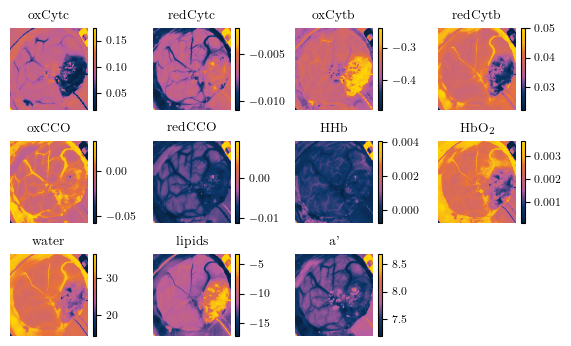

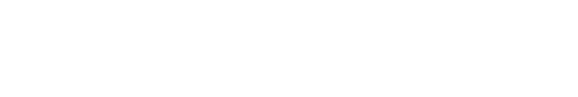

100%|██████████| 575/575 [00:16<00:00, 34.34it/s]


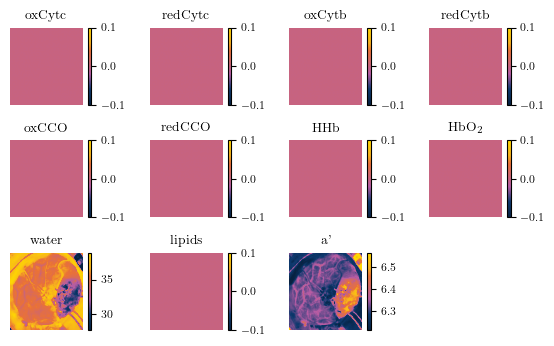

In [29]:
fig_heatmaps = lmm_unmixing(absorbance, M_lit, plot_hm=True, gt_map=gt_map)
plot_ref_full()
fig_heatmaps.savefig(f"../../figures/lin_unmixing_{img}.svg", bbox_inches="tight", format="svg", dpi=600)

fig_heatmaps = nonneg_lmm_unmixing(absorbance, M_lit, plot_hm=True, gt_map=gt_map)
fig_heatmaps.savefig(f"../../figures/nonneg_unmixing_{img}.svg", bbox_inches="tight", format="svg", dpi=600)

100%|██████████| 575/575 [00:10<00:00, 56.78it/s]


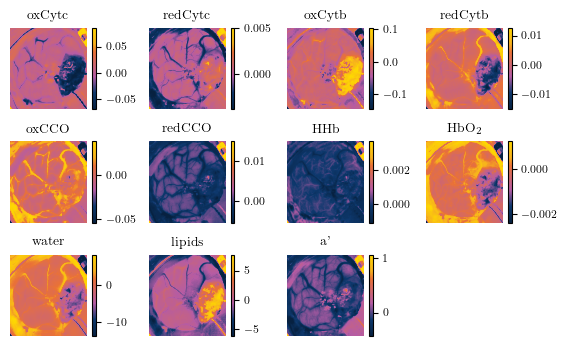

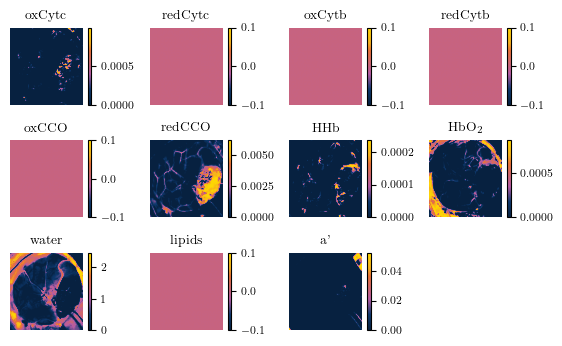

In [30]:
fig_heatmaps = lmm_unmixing(rel_absorbance, M_lit, plot_hm=True, gt_map=gt_map)
fig_heatmaps.savefig(f"../../figures/lin_unmixing_rel_{img}.svg", bbox_inches="tight", format="svg", dpi=600)
fig_heatmaps = nonneg_lmm_unmixing(rel_absorbance, M_lit, plot_hm=True, gt_map=gt_map)
fig_heatmaps.savefig(f"../../figures/nonneg_unmixing_rel_{img}.svg", bbox_inches="tight", format="svg", dpi=600)

100%|██████████| 575/575 [00:10<00:00, 55.04it/s]


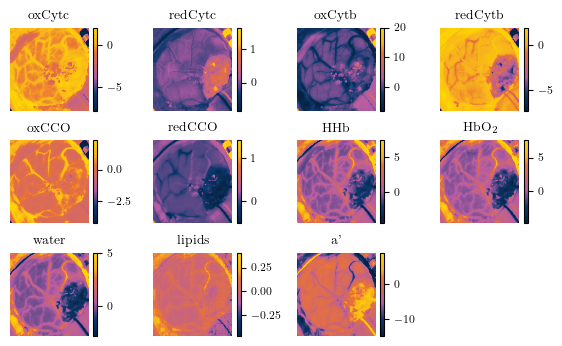

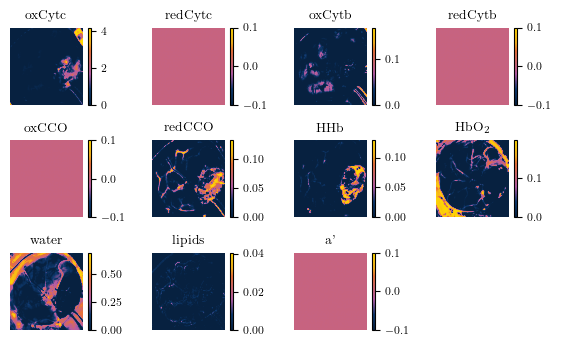

In [31]:
fig_heatmaps = lmm_unmixing(rel_absorbance, M_mc, plot_hm=True, gt_map=gt_map)
fig_heatmaps.savefig(f"../../figures/lin_unmixing_rel_mc_{img}.svg", bbox_inches="tight", format="svg", dpi=600)
fig_heatmaps = nonneg_lmm_unmixing(rel_absorbance, M_mc, plot_hm=True, gt_map=gt_map)
fig_heatmaps.savefig(f"../../figures/nonneg_unmixing_rel_mc_{img}.svg", bbox_inches="tight", format="svg", dpi=600)

### Run tests on whole dataset

In [12]:
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]

database_folder = "../../datasets/npj_database"
absorbance_all = []
rel_absorbance_all = []
labels_all = []
R_all = []
for img_folder in os.listdir(database_folder):
    if os.path.isdir(os.path.join(database_folder,img_folder)):
        img_absorbance = np.load(os.path.join(database_folder,img_folder,"preprocessed.npy"))
        img_gt_map = sp.open_image(os.path.join(database_folder,img_folder,"gtMap.hdr")).asarray().squeeze()

        normal_idxs = np.where(img_gt_map == 1)
        if len(normal_idxs[0]) == 0:
            continue
        R_all.append(np.load(os.path.join(database_folder,img_folder,"corr_matrix.npy")))
        absorbance_all.append(img_absorbance[img_gt_map != 0])
        labels_all.append(img_gt_map[img_gt_map != 0])
        ref_absorbance = img_absorbance[normal_idxs[0][0],normal_idxs[1][0]]
        rel_absorbance_all.append(img_absorbance[img_gt_map != 0] - ref_absorbance)

absorbance_all = np.concatenate(absorbance_all, axis=0) 
rel_absorbance_all = np.concatenate(rel_absorbance_all, axis=0)
labels_all = np.concatenate(labels_all, axis=0)

In [13]:
# select 5000 random pixels from each class
np.random.seed(0)
n = 5000
idxs = []
for i in range(1,4):
    idx = np.where(labels_all == i)[0]
    idxs.append(np.random.choice(idx,n,replace=False))
idxs = np.concatenate(idxs, axis=0)
absorbance_subset = absorbance_all[idxs]
rel_absorbance_subset = rel_absorbance_all[idxs]
labels_subset = labels_all[idxs]